# Lab2 - Concrete compressive strength regression (35 marks total)
Author: Jean-Charl Pretorius

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Function definitions (2 marks)

To find the best model, we follow the published article where root-mean squared error (rms) was used as a score function. The rms score function needs to be minimized, because the optimal score is 0, larger values are worse performances

In scikit-learn, only *maximization* is implemented. Hence, it is customary to maximize the *negative* rms. scitkit-learn provides a scoring function `neg_root_mean_squared_error`

In [55]:
from sklearn.model_selection import cross_validate


def get_regressor_neg_rms(model, X, y, cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms)
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    
    # cross validation
    res = cross_validate(model, X=X, y=y, cv=cv, scoring='neg_root_mean_squared_error', return_train_score=True)

    # get training and test scores
    testing_score = res['test_score'].mean()
    training_score = res['train_score'].mean()
    
    return training_score, testing_score
    

## 1. Load data (1 mark each for 3 total marks)
yellowbrick concrete  
https://www.scikit-yb.org/en/latest/api/datasets/concrete.html

Load the Dataset object with `load_concrete()` using `return_dataset=True`

Print the README of the Dataset object


In [19]:
from yellowbrick.datasets import load_concrete

concrete_dataset = load_concrete(return_dataset=True)
print(concrete_dataset.README)

# Concrete Compressive Strength

**Downloaded from the UCI Machine Learning Repository on October 13, 2016.**

- Multivariate Data Set
- Real Attributes
- 1,030 Instances
- 9 attributes
- Well suited for _regression_ tasks
- [https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

## Abstract

Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.

## Description

Given are the variable name, variable type, the measurement unit and a brief description. The concrete compressive strength is the regression problem. The order of this listing corresponds to the order of numerals along the rows of the database.

## Attributes

- cement (kg)
- blast furnace slag (kg)
- fly ash (kg)
- water (kg)
- superplasticizer (kg)
- coarse aggregate (kg)
- fine aggregate (kg)
- age (day)
- compressive strength (MPa)

## Citat

### *Question 1:* What is the target variable name and units in this dataset?

The target variable name is compressive strength and the units are MPa


### 1.1 Prepare the feature matrix and target vector
Load the concrete data set into feature matrix `X` and target vector `y`

Print dimensions and type of `X`, `y`

In [21]:
X, y = load_concrete()
print("Shape of X: {}".format(X.shape))
print("Type of X: {}".format(type(X)))

print("\nShape of y: {}".format(y.shape))
print("Type of y: {}".format(type(y)))

Shape of X: (1030, 8)
Type of X: <class 'pandas.core.frame.DataFrame'>

Shape of y: (1030,)
Type of y: <class 'pandas.core.series.Series'>


## 2. Inspect the data (1 mark each for 4 total marks)

### 2.1 Range of each feature
To get an idea if the features are on the same scale, we inspect the range of features

Print the minimum and maximum of each feature in `X`

In [17]:
X.describe().loc[['min', 'max'], :]


,cement,slag,ash,water,splast,coarse,fine,age
min,102.0,0.0,0.0,121.75,0.0,801.0,594.0,1.0
max,540.0,359.4,200.1,247.00,32.2,1145.0,992.6,365.0


### 2.2 Boxplot of features 
Using seaborn boxplot, plot all features. This provides a visual view of feature ranges

Add y-axis label indicating units, and a title

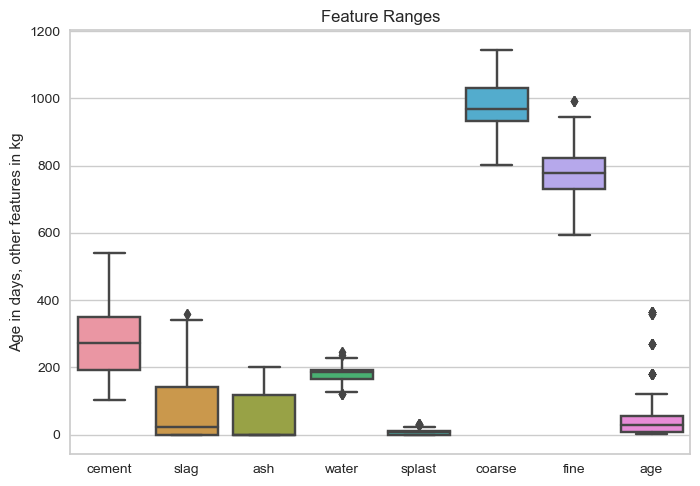

In [25]:
import seaborn as sns
sns.boxplot(data=X)
plt.title("Feature Ranges")
plt.ylabel("Age in days, other features in kg");


### 2.3 Correlation heatmap of features 

To understand if pairs of features are potentially related, contain similar information, pair-wise cross-correlation can be calculated. Models benefit most from un-correlated features.

Using pandas `corr()` method, create the cross-correlations between all features. Plot this cross-correlation object using seaborn `heatmap()` with parameters `vmin=-1, vmax=1, annot=True, cmap='BrBG'`. Add a title.

Pandas `corr()` calculates [Pearson correlation ](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) :
>  It has a value between +1 and −1. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

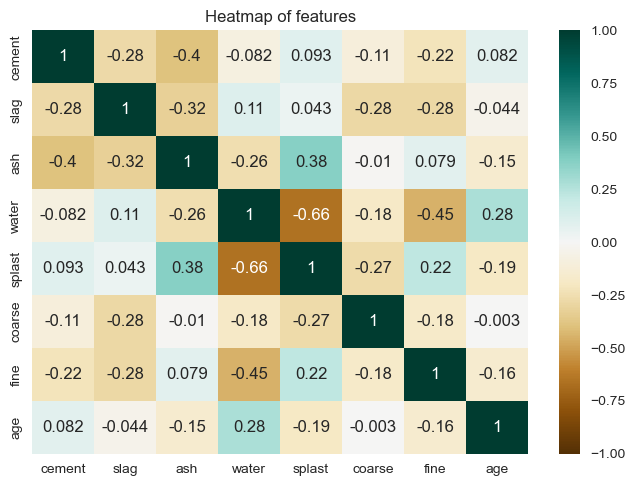

In [26]:
corr = X.corr()
sns.heatmap(data=corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title("Heatmap of features");


### 2.4 Histogram of target variable 

To understand if all target values are equally represented in the data, we analyze how many samples of each target value we have available. The histogram of the target vector can visualize this distribution.

Using seaborn `displot()`, plot the histogram of the target vector. Add a title.

Text(0.5, 1.0, 'Histogram of Compressive Strength')

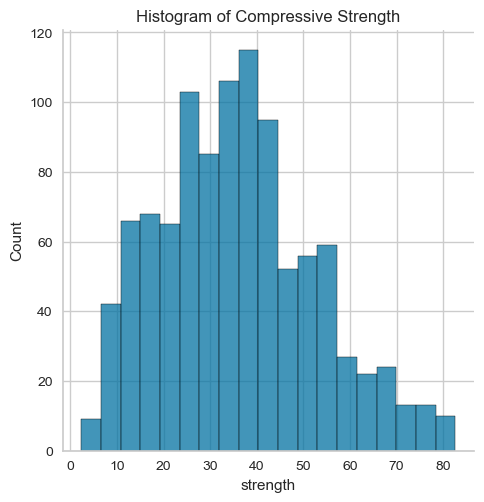

In [28]:
sns.displot(data=y)
plt.title('Histogram of Compressive Strength')


## 3. Create training and test sets (1 mark)

Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X` and `y` into training and test sets

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37, test_size=0.2)


## 4. Compare models using cross-validation (3 marks)

Create a list containing a `LinearRegression()`, `RandomForestRegressor(random_state=64)` and `GradientBoostingRegressor(random_state=79)` objects.

Iterate this list and:
- using `X_train` and `y_train`
- compute the negative root mean-squared error using the `get_regressor_neg_rms()` function
- and print the training and validation scores with **2 decimal places**
- Use 7-fold cross-validation

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [60]:
models = [LinearRegression(), RandomForestRegressor(random_state=64), GradientBoostingRegressor(random_state=79)]
model_names = ['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor']

for model, name in zip(models, model_names):
    
    training_score, testing_score = get_regressor_neg_rms(model, X_train, y_train, 7)
    
    print("\n{}:".format(name))
    print("\tTraining score: {:.2f}".format(training_score))
    print("\tTesting score: {:.2f}".format(testing_score))
    



Linear Regression:
	Training score: -10.29
	Testing score: -10.39

Random Forest Regressor:
	Training score: -2.12
	Testing score: -4.97

Gradient Boosting Regressor:
	Training score: -3.69
	Testing score: -4.98


### *Question 2:* For each of the three models, state if models are potentially over- or underfitting and why (3 marks)

For linear regression, the model is likely underfitting. The training and testing scores are low and very similar, indicating high bias.


For the Random Forest Regressor, the model performs better but there is greater variance between the training and testing scores. It is potentially overfitting the data.


For the Gradient Boosting Regressor, the model has a lower training score and less variance than the random forest regressor but still high. It is potentially overfitting the data.



## 5. Find a better model (3 marks)

Use the `RandomForestRegressor(random_state=64)` and find the best combination of `max_depth` from the list of `[10, 15, 20]`, and `n_estimators` from the list of `[100, 200, 400]`

Use nested for-loops to iterate these two lists:
- using `X_train` and `y_train`
- compute the negative root mean-squared error of the corresponding `RandomForestRegressor(random_state=64)` using the `get_regressor_neg_rms()` function 
- and print the training and validation scores with **2 decimal places**
- Use 7-fold cross-validation

Report the best validation score and the corresponding model

Note: We expect that more trees (larger `n_estimators`) yield better model performance

In [66]:
best_score = -999
for max_depth in [10, 15, 20]:
    for n_estimators in [100, 200, 400]:
        # get scores 
        training_score, validation_score = get_regressor_neg_rms(RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=64), X_train, y_train, 7)    
        if validation_score > best_score:
            best_score = validation_score
            best_parameters = {'max_depth': max_depth, 'n_estimators': n_estimators}
        
        # print scores
        print("\nMax_depth: {}, n_estimators: {}".format(max_depth, n_estimators))
        print("Training score: {:.2f}".format(training_score))
        print("Testing score: {:.2f}".format(validation_score)) 


print("\nBest validation score: {:.2f}".format(best_score)) 
print("Best parameters: max_depth: {}, n_estimators: {}".format(best_parameters['max_depth'], best_parameters['n_estimators']))



Max_depth: 10, n_estimators: 100
Training score: -2.44
Testing score: -5.09

Max_depth: 10, n_estimators: 200
Training score: -2.42
Testing score: -5.06

Max_depth: 10, n_estimators: 400
Training score: -2.41
Testing score: -5.06

Max_depth: 15, n_estimators: 100
Training score: -2.12
Testing score: -4.97

Max_depth: 15, n_estimators: 200
Training score: -2.11
Testing score: -4.93

Max_depth: 15, n_estimators: 400
Training score: -2.10
Testing score: -4.93

Max_depth: 20, n_estimators: 100
Training score: -2.12
Testing score: -4.97

Max_depth: 20, n_estimators: 200
Training score: -2.11
Testing score: -4.93

Max_depth: 20, n_estimators: 400
Training score: -2.09
Testing score: -4.92

Best validation score: -4.92
Best parameters: max_depth: 20, n_estimators: 400


### *Question 3:* Which combination of `max_depth` and `n_estimators` produced the best validation score? Report both training and validation scores here (2 marks)

The best validation score was achieved with the following hyperparameters:

- max_depth: 20
- n_estimators: 400

With this combination, the scores are:

- training score: -2.09
- validation score: -4.92


## 6. Retrain best model (2 marks)

Create a `RandomForestRegressor(random_state=64)` with the best pair of `max_depth` and `n_estimators`, and retrain this model on all training data.

In [65]:
random_forest = RandomForestRegressor(n_estimators=400, max_depth=20, random_state=64)
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=400, random_state=64)

## 7. Evaluate best model on training and test data
### 7.1 Root mean-squared error and $R^2$ (3 marks)

For the retrained best estimator, print the root mean-squared error (**2 decimal places**) and R-squared (**3 decimal places**) for training and test sets.

In [67]:
from sklearn.metrics import mean_squared_error, r2_score

In [73]:
# TODO: print rms and r-squared for training and test set
# training set
y_train_pred = random_forest.predict(X_train)
train_rms = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# testing set
y_test_pred = random_forest.predict(X_test)
test_rms = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# print scores/errors:
print("Training set:\n\tRoot mean-squared error: {:.2f} MPa\n\tR2 score: {:.3f}".format(train_rms, train_r2))
print("\nTest set:\n\tRoot mean-squared error: {:.2f} MPa\n\tR2 score: {:.3f}".format(test_rms, test_r2))



Training set:
	Root mean-squared error: 2.00 MPa
	R2 score: 0.986

Test set:
	Root mean-squared error: 4.80 MPa
	R2 score: 0.915


### *Question 4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models? Include scores in your answer. (2 marks)

A lower root mean-squared error and a R2 score closer to 1 is indicative of a model that peforms well.

The test score for our random forest model gives us a root mean-squared error error of 4.80 MPa with R2 = 0.915. 

This is better than the polynomial regression model in the article:
- RMS of 4.80 MPa is lower than 8.82 MPa for polynomial regression
- R2 of 0.915 is higher than 0.791 for polynomial regression


This model is worse than the neural network models in the article:
- RMS of 4.80 MPa is higher than 4.32 MPa for neural network
- R2 of 0.915 is lower than 0.929 for  neural network


### 7.2 Predicted vs actual strength plot (1 mark)
Using a scatterplot, show predicted strength on the x axis and actual strength on the y axis with data from the test set. With this plot, we can see where we make errors.

Add a line of unity (diagonal with slope 1 and offset 0). Ideally, all points would be on this line. We look for points being distributed equally around the line of unity.

Add x-axis, y-axis labels including units, and a title.


In [ ]:
#TODO: predicted-actual plot


### 7.3 Residual plot (1 mark)
Using a scatterplot, show predicted strength on the x axis and the *difference* between actual and predicted strength on the y axis with data from the test set. This is an alternative way to see where errors are made.

We look for residuals being distributed equally around the zero horizontal line.

Add x-axis, y-axis labels including units, and a title.



In [ ]:
# TODO: Residual plot


## 8. Conclusion (3 marks)

In conclusion, comment on the following items:
1. Did we find a model that outperforms the polynomial regression reported in the reference article? Explain.
1. Did we find a model that outperforms the neural network reported in the reference article? Explain.
1. What were our assumption about the dataset and train/test split? How do these assumptions affect your conclusions?


*YOUR ANSWER HERE*


## 9. Reflection (2 marks)



Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment.

*ADD YOUR THOUGHTS HERE*

# Appendix-A: Bonus - use grid search to find the best model parameters
### (5 potential bonus marks)

## A-0. Workflow overview

In [ ]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## A-1. Hyperparameter tuning using grid search (2 marks)

The inital cross-validation above showed that both DecisionTree based models might have merit. Next, the hyperparameters are tuned using grid search.

### A-1.1 Grid search for RandomForestRegressor

Perform grid search using `GridSearchCV` for the `RandomForestRegressor(random_state=64)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 400]`
- `'max_depth': [ 15, 17, 19, 21]`
- `'max_features': ['auto', 'log2', None]`


In [ ]:
# TODO: Setup grid search for RandomForestRegressor(random_state=64)


In [ ]:
# TODO: perform the grid search by calling fit()


In [ ]:
# TODO: Print the best parameters


In [ ]:
# TODO: Print the best score


### A-1.2 Grid search for gradient boosted tree

Perform grid search using `GridSearchCV` for the `GradientBoostingRegressor(random_state=79)`.

Grid search to use 7-fold cross-validation, and `neg_root_mean_squared_error` as the scoring function.

Use the following hyperparameters and values:
- `'n_estimators': [100, 200, 500]`
- `'max_depth': [1, 3, 5, 7]`
- `'learning_rate': [0.01, 0.1, 1.0]`

In [ ]:
# TODO: Setup grid search for GradientBoostingRegressor(random_state=79)


In [ ]:
# TODO: perform the grid search by calling fit()


In [ ]:
# TODO: Print the best parameters


In [ ]:
# TODO: Print the best score


### *Question A-1:* Which of the two models produces the best score? What is the best score?

*YOUR ANSWER HERE*


## A-2. Retrain best model (1 mark)

Get the best estimator from the two grid searches above and retrain this model on all training data.

In [ ]:
#TODO: retrain the best estimator



## A-3. Model evaluation and conclusion (1 mark)

Repeat steps in Section 7 above for the best model.

Revisit your Question 4.

In [ ]:
#TODO: train and test set scores of retrained best model


In [ ]:
#TODO: predicted-actual plot


In [ ]:
# TODO: Residual plot


### *Question A-4:* How does this test score compare to the polynomial regression and neural network reported in the article? Do we outperform the reported models? (1 mark)

*YOUR ANSWER HERE*
